In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray
import pandas as pd

/home/ckaul/.conda-envs/my_env/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [3]:
import sys
sys.path.append('/home/ckaul/DriesNotebook/')

In [4]:
from mmctools.dataloaders import read_dir
from mmctools.wrf.utils import extract_column_from_wrfdata
from mmctools.coupling.internal_nalu import NaluInput
from mmctools.helper_functions import calc_wind

In [5]:
from mmctools.plotting import plot_timehistory_at_height, plot_profile

Define some physical constants

In [6]:
g  = 9.81            # Gravity [m s-2]
T0 = 300             # Reference temperature for perturbation temperature [K]
K  = 0.41            # von Karman constant
R_air = 287.058      # Specific gas constant for dry air [J kg-1 K-1]
Cp_air = 1005        # Specific heat of air [J kg-1 K-1]
P0 = 100000          # Reference pressure [Pa]
kappa = R_air/Cp_air # Poisson constant

# Extract WRF data at a specific site and write as internal forcing for SOWFA

Input files

In [7]:
dpath = '/projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/'
file_filter  = 'mmc_d03_*'

SWIFT site coordinates

In [8]:
site_latitude  = 33.61054
site_longitude = -102.05054

Some parameters for extracting site data

In [9]:
# Define how WRF data is filtered to site specific data
# - 'interpolate': interpolate to site coordinates
# - 'nearest': use nearest WRF grid point
# - 'average': average of an area L_filter x Lfilter centred around the site
spatial_filter = 'interpolate'
L_filter = 0.0

# Define microscale vertical grid
Ztop = 2000.0 # Column height [m]
Vres = 10.0 #5.0    # Vertical resolution [m]

Output file to save WRF data at SWiFT site for later data analysis

In [10]:
output = 'WRF_20131108-09.nc'

## Read WRF data

In [11]:
%%time
xa = read_dir(dpath, file_filter=file_filter,
              reader=extract_column_from_wrfdata,
              verbose=True,
              coords=(site_latitude,site_longitude),
              spatial_filter=spatial_filter,L_filter=L_filter,
              Ztop=Ztop,Vres=Vres,
             )

Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_00:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_01:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_02:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_03:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_04:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_05:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_06:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_07:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_08:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_09:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_10:00:00
Reading /p

In [12]:
xa.to_dataframe().head()

U10       V10          T2         TSK     UST  \
Time       height                                                       
2013-11-08 0.0     0.476011  4.922308  284.730595  282.509583  0.0001   
           10.0    0.476011  4.922308  284.730595  282.509583  0.0001   
           20.0    0.476011  4.922308  284.730595  282.509583  0.0001   
           30.0    0.476011  4.922308  284.730595  282.509583  0.0001   
           40.0    0.476011  4.922308  284.730595  282.509583  0.0001   

                           PSFC  HFX   LH  MUU  MUV  ...  RU_TEND_ADV  \
Time       height                                    ...                
2013-11-08 0.0     91081.066806  0.0  0.0  0.0  0.0  ...          0.0   
           10.0    91081.066806  0.0  0.0  0.0  0.0  ...          0.0   
           20.0    91081.066806  0.0  0.0  0.0  0.0  ...          0.0   
           30.0    91081.066806  0.0  0.0  0.0  0.0  ...          0.0   
           40.0    91081.066806  0.0  0.0  0.0  0.0  ...          0.0   

                   RU_TEND_PGF  RU_TEND_COR  RU_TEND_PHYS  RV_TEND  \
Time       height                                                    
2013-11-08 0.0             0.0          0.0           0.0      0.0   
           10.0            0.0          0.0           0.0      0.0   
           20.0            0.0          0.0           0.0      0.0   
           30.0            0.0          0.0           0.0      0.0   
           40.0            0.0          0.0           0.0      0.0   

                   RV_TEND_ADV  RV_TEND_PGF  RV_TEND_COR  RV_TEND_PHYS  \
Time       height                                                        
2013-11-08 0.0             0.0          0.0          0.0           0.0   
           10.0            0.0          0.0          0.0           0.0   
           20.0            0.0          0.0          0.0           0.0   
           30.0            0.0          0.0          0.0           0.0   
           40.0            0.0          0.0          0.0           0.0   

                   T_TEND_ADV  
Time       height              
2013-11-08 0.0            0.0  
           10.0           0.0  
           20.0           0.0  
           30.0           0.0  
           40.0           0.0  

[5 rows x 26 columns]

## Process data

In [13]:
# Round timestamp to 10min
xa['Time'] = xa['Time'].dt.round('10min')

Rescale tendencies with MU*

In [14]:
fieldnames_muu = ['RU_TEND','RU_TEND_ADV','RU_TEND_PGF','RU_TEND_COR','RU_TEND_PHYS']
fieldnames_muv = ['RV_TEND','RV_TEND_ADV','RV_TEND_PGF','RV_TEND_COR','RV_TEND_PHYS']
fieldnames_mut = ['T_TEND_ADV',]
for field in fieldnames_muu:
    xa[field].values = xa[field].values/xa['MUU'].values[:,np.newaxis]
for field in fieldnames_muv:
    xa[field].values = xa[field].values/xa['MUV'].values[:,np.newaxis]
for field in fieldnames_mut:
    xa[field].values = xa[field].values/xa['MUT'].values[:,np.newaxis]

/home/ckaul/.conda-envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/ckaul/.conda-envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/ckaul/.conda-envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/ckaul/.conda-envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/ckaul/.conda-envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/ckaul/.conda-envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


Compute additional surface parameters

In [ ]:
rho = xa['PSFC'] / (R_air*xa['T2'])

# Kinematic heat flux
xa['wt']  = xa['HFX'] / (Cp_air*rho)
xa['wt'].attrs['description'] = 'kinematic heat flux'
xa['wt'].attrs['units'] = 'K m s-1'

# Obukhov length
xa['L0']  = -xa['UST']**3 * xa['T2'] / (K * g * xa['wt'])
xa['L0'].attrs['description'] = 'Obukhov length'
xa['L0'].attrs['units'] = 'm'

Compute potential temperature from T2 and TSK

In [ ]:
# Surface skin potential temperature
xa['thetaSK'] = xa['TSK'] * (P0/xa['PSFC'])**kappa
xa['thetaSK'].attrs['desccription'] = 'surface skin potential temperature'
xa['thetaSK'].attrs['units'] = 'K'

# Potential temperature at 2 m
xa['theta2'] = xa['T2'] * (P0/xa['PSFC'])**kappa
xa['theta2'].attrs['desccription'] = 'potential temperature at 2 m'
xa['theta2'].attrs['units'] = 'K'

Save WRF column data

In [ ]:
%%time
xa.to_netcdf(output,'w',format='NETCDF4')

Apply temporal averaging (currently not used)

## Write data as SOWFA input file

In [15]:
dateref = '2013-11-08 00:00:00'
datefrom = '2013-11-08 12:00:00'
dateto = '2013-11-09 12:00:00'

In [16]:
dirout = '/projects/mmcpnnl/ckaul/wrf2nalu/'

In [17]:
# Generate dataframe with U, V, W, theta and their tendencies
xa['FU'] = xa['RU_TEND_PGF'] + xa['RU_TEND_ADV']
xa['FV'] = xa['RV_TEND_PGF'] + xa['RV_TEND_ADV']

df = xa.to_dataframe().loc[:,['U','V','W','theta','FU','FV','T_TEND_ADV']].reset_index()
df.rename(index=str, columns={"Time": "datetime"},inplace=True)
df.set_index('datetime',inplace=True)

In [18]:
%%time
to_nalu = NaluInput(dirout,df,dateref,datefrom,dateto)
to_nalu.write_ICs('initialValues',xmom='U',ymom='V',temp='theta')
# to_sowfa.write_timeheight('fieldTable',xmom='U',ymom='V',zmom='W',temp='theta')
to_nalu.write_timeheight('forcingTable',xmom='FU',ymom='FV',zmom='FW',temp='T_TEND_ADV')
#Note: FW does not exist so will be set to zero

(145, 201)
(145, 201)
(145, 201)
(145, 201)
CPU times: user 1.95 s, sys: 25.4 ms, total: 1.98 s
Wall time: 122 ms


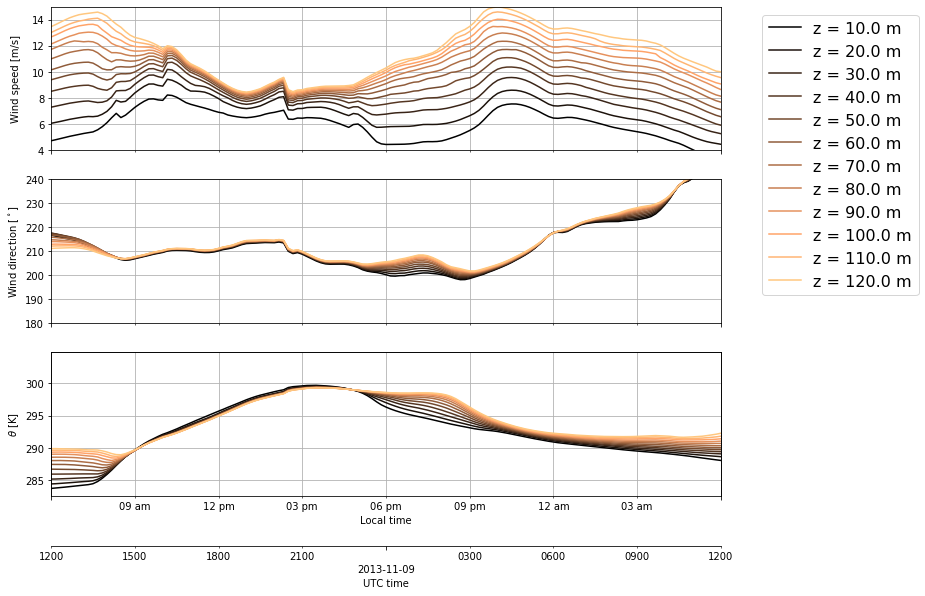

In [19]:
df['wspd'], df['wdir'] = calc_wind(df,'U','V')
fig,ax,ax2 = plot_timehistory_at_height(
    df,
    fields=['wspd','wdir','theta'],
    heights=np.linspace(10,120,12),
    cmap='copper',
    timelimits=['2013-11-08 12:00','2013-11-09 12:00'],
    fieldlimits={'wspd':(4,15),'wdir':(180,240)},
    plot_local_time=True,
    local_time_offset=-6
)

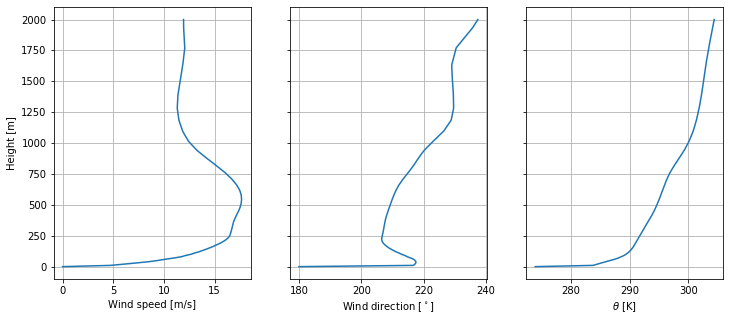

In [20]:
fig,ax = plot_profile(
    df,
    fields=['wspd','wdir','theta'],
    times='2013-11-08 12:00',
    fieldlabels={'theta':r'$\theta$ [K]'},
    showlegend=False
)

In [ ]:
# Generate dataframe with surface parameters
df_bc = xa.to_dataframe().loc[:,['TSK','T2','thetaSK','theta2','wt']].reset_index()
df_bc.rename(index=str, columns={"Time": "datetime"},inplace=True)
df_bc.set_index('datetime',inplace=True)
df_bc = df_bc.loc[df_bc.height==0].copy()

In [ ]:
%%time
to_sowfabc = SowfaInput(dirout,df_bc,dateref,datefrom,dateto)
to_sowfabc.write_BCs('surfaceSkinTemperatureTable',fieldname='TSK')
to_sowfabc.write_BCs('surface2mTemperatureTable',fieldname='T2')
to_sowfabc.write_BCs('surfaceSkinPotentialTemperatureTable',fieldname='thetaSK')
to_sowfabc.write_BCs('surface2mPotentialTemperatureTable',fieldname='theta2')
to_sowfabc.write_BCs('surfaceTemperatureFluxTable',fieldname='wt',fact=-1.0)

In [ ]:
df_bc.head()

In [ ]:
fig,ax,ax2 = plot_timehistory_at_height(
    df_bc,
    fields=['thetaSK','wt'],
    heights=0.0,
    timelimits=['2013-11-08 12:00','2013-11-09 12:00'],
    fieldlabels={'thetaSK':r'$\theta_s$ [K]','wt':r'$q_w$ [Km/s]'},
    showlegend=False,
    plot_local_time=True,
    local_time_offset=-6
)